# Import library

In [1]:
import re
import string
import codecs
import pickle
import pandas as pd
import numpy as np
from collections import Counter
import datetime
import math
import emoji
import regex

import seaborn as sns
import matplotlib.pyplot as plt

import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS


import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import words
from stop_words import get_stop_words

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from numpy.random import seed
from tensorflow import random
from keras.regularizers import l2
from keras.regularizers import l1
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.callbacks import EarlyStopping



from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords,wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


from scipy import stats
random.set_seed(112)
seed(112)

ModuleNotFoundError: No module named 'emoji'

# Data Preparation

In [186]:
df = pd.read_csv("twitter_data(all).csv")
#df2 = pd.read_csv("twitter_Media_data(7-days).csv")
#df = df.append(df2)
#df.reset_index(inplace=True,drop=True)
#df = df.iloc[df['Text'].drop_duplicates().index]
#df.reset_index(inplace=True,drop=True)
#df

# Extract features

In [187]:
#words count column
my_stopwords = nltk.corpus.stopwords.words('english')
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

def words_count(text):
    text = str.lower(text)
    text = re.sub('['+ my_punctuation + ']+', ' ', text)
    text = TweetTokenizer().tokenize(text)
    text = [word for word in text 
                        if word not in my_stopwords]
    count = len(text)
    return count

df['words_count'] = df['Text'].apply(words_count)    

In [188]:
#greeting column (time)
df['Date'] = pd.to_datetime(df['Date'])
df['hours'] = df['Date'].dt.hour

def greeting(hours):
    if hours in range(5,12):
        h = 'morning'
    elif hours in range(12,18):
        h = 'afternoon'
    elif hours in range(18,21):
        h = 'evening'
    else:
        h = 'night'
    return h

df['greeting'] = df.hours.apply(greeting)

In [189]:
#Weekday
def name_the_day(day):
    if day == 0:
        return "Monday"
    elif day == 1:
        return "Tuesday"
    elif day == 2:
        return "Wednesday"
    elif day == 3:
        return "Thursday"
    elif day == 4:
        return "Friday"
    elif day == 5:
        return "Saturday"
    else:
        return "Sunday"
    
df['Day of Weeks'] = df['Date'].dt.dayofweek.apply(name_the_day)

In [190]:
#hashtag counts/len hashtag

def hashtags_count(hashs):
    if pd.notna(hashs) :
        hashs = str(hashs)
        hashs = hashs.split(',')
        counts = len(hashs)
    else:
        counts = 0
    return counts

def length_h(hashs):
    hashs = str(hashs).replace(',','')
    count = len(list(hashs))
    return count

df['hashtags_count'] = df.Hashtags.apply(hashtags_count)
df['length_hashtag'] = df.Hashtags.apply(length_h)


In [191]:
#User mention counts

df['User Mentions'] = df['User Mentions'].fillna(0)
CountUser = list()

for i in range(len(df['User Mentions'])):
    text = df['User Mentions'][i]
    if df['User Mentions'][i] != 0 :
        words = text.split(',')
        lenW = len(words)
        CountUser.append(lenW)
    else:
        CountUser.append(0)
        
CountUser = pd.DataFrame(CountUser)

CountUser = CountUser.rename(columns={0:"User Mentions count"})
df = pd.concat([df,CountUser],axis=1)

In [192]:
#Dummy media
df.loc[df['Media'].notnull(),'Media'] = 1
df.loc[df['Media'].isnull(),'Media'] = 0
df['Media'] = df['Media'].astype(int)

In [193]:
#Emoji counts
def count_emoji(text):
    emoji = re.compile('[\\u203C-\\u3299\\U0001F000-\\U0001F644]')
    emo = list(filter(emoji.match, text))
    count = len(emo)
    return count
df['emoji_count'] = df['Text'].apply(count_emoji)  

In [194]:
#Engagement
df['Engagement'] = df['Favorite count'] + df['Retweet count']

In [195]:
#Clean reply tweet
indexlist = []
for i in df.index:
    if df['Text'][i][0] == '@' and df['Engagement'][i] <=10:
        index = i
        indexlist.append(i)
        
df.drop(indexlist,inplace=True)
df.reset_index(drop=True,inplace=True)

In [196]:
#Count vecterization

countVect = CountVectorizer()

def getWordnetPos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else: 
        return None
    
myStopwords = stopwords.words('english')
myStopwords.append('would')
myStopwords.append('thing')
myStopwords.append('want')
myStopwords.append('thanks')
myStopwords.append('https')
myStopwords.append('every')
myStopwords.append('re')
myStopwords.append('the')
myStopwords.append('co')
myStopwords.append('http')
myStopwords.append('amp')
myStopwords.append('ll')



lemmatizer = WordNetLemmatizer()
corpus = list()

for text in df['Text']:
    
    tweetText = text.lower()
    tweetText = tweetText.replace('\n', ' ')
    tweetText = re.sub(r'[^\x00-\x7F]','',tweetText) #Remove Non-ASCII Charactors (i.e. emoji and etc.)
    tweetText = re.sub(r'[(,),!]','',tweetText)

    wordLem = list()
    sentences = sent_tokenize(tweetText)
    for sentence in sentences:
        words = word_tokenize(sentence)
        wordPos = nltk.pos_tag(words)
        for w,p in wordPos:
            wntag = getWordnetPos(p)
            if wntag is None:
                wordLem.append(lemmatizer.lemmatize(w))
            else:
                wordLem.append(lemmatizer.lemmatize(w, pos=wntag))
        
    wordLem = [w for w in wordLem if len(w) > 2]
    wordLem = [w for w in wordLem if w not in myStopwords]
    
    wordSentenceLem = ' '.join(wordLem)
    corpus.append(wordSentenceLem)
    
countVect = CountVectorizer(max_features=50)
cvCorpus = countVect.fit_transform(corpus)

textFeatures = pd.DataFrame(cvCorpus.toarray(), columns=countVect.get_feature_names())
textFeatures

,2021,best,business,co,collection,come,covid,day,first,get,...,use,video,vote,watch,way,wear,woman,work,world,year
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12591,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12592,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
12593,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12594,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [197]:
#Combine
df = pd.concat([df.drop(columns = ['Date','Favorite count','Retweet count','ID','Name','Text','Hashtags','User Mentions','Location','Symbols','Source']), textFeatures], axis=1)
df = pd.get_dummies(df)

# Target feature

In [198]:
#Split 4 Qt
df['Class'] = np.nan
df.loc[(df['Class'].isnull()) & (df['Engagement']<=df['Engagement'].quantile(0.25)),'Class'] = 'Q1'
df.loc[(df['Class'].isnull()) & (df['Engagement']<=df['Engagement'].quantile(0.50)),'Class'] = 'Q2'
df.loc[(df['Class'].isnull()) & (df['Engagement']<=df['Engagement'].quantile(0.75)),'Class'] = 'Q3'
df.loc[(df['Class'].isnull()) & (df['Engagement']<=df['Engagement'].quantile(1)),'Class'] = 'Q4'
df.drop(columns='Engagement',inplace=True)

# Train/Test/Val split and normalization

In [199]:
#Train test val split
train, validate, test = np.split(df.sample(frac=1, random_state=42),[int(.6*len(df)), int(.8*len(df))])

X_train = train.loc[:, train.columns != 'Class']
y_train = train.loc[:, train.columns == 'Class']

X_validation = validate.loc[:, validate.columns != 'Class']
y_validation = validate.loc[:, validate.columns == 'Class']

X_test = test.loc[:, test.columns != 'Class']
y_test = test.loc[:, test.columns == 'Class']

In [200]:
X_train.iloc[:,1:9]

,Follower count,Friends count,Status count,words_count,hours,hashtags_count,length_hashtag,User Mentions count
8822,114167577.0,290893.0,31342.0,14,18,1,8,2
7820,2294552.0,12932.0,191869.0,7,11,0,3,3
3068,53299013.0,1101.0,336311.0,18,15,0,3,0
6472,70831.0,24704.0,63589.0,15,13,0,3,0
9825,82714470.0,56751.0,46868.0,16,16,0,3,1
...,...,...,...,...,...,...,...,...
5077,30957219.0,915.0,12576.0,17,18,0,3,1
4101,31434235.0,70.0,323821.0,12,12,0,3,0
8137,1438925.0,386.0,199041.0,16,13,1,7,1
2722,3825603.0,444.0,201706.0,5,14,0,3,1


In [201]:
#normalization (all except dummies)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_trainN = scaler.fit_transform(X_train.iloc[:,1:9])
X_validationN = scaler.transform(X_validation.iloc[:,1:9])
X_testN = scaler.transform(X_test.iloc[:,1:9])

In [202]:
#merge normalized data with all dummies
df_train_dummies = pd.concat([X_train.iloc[:,0],X_train.iloc[:,10:]],axis=1)
X_train_dummy = np.array(df_train_dummies)
X_train = np.concatenate((X_trainN,X_train_dummy),axis=1)

df_validation_dummies = pd.concat([X_validation.iloc[:,0],X_validation.iloc[:,10:]],axis=1)
X_validation_dummy = np.array(df_validation_dummies)
X_validation = np.concatenate((X_validationN,X_validation_dummy),axis=1)

df_test_dummies = pd.concat([X_test.iloc[:,0],X_test.iloc[:,10:]],axis=1)
X_test_dummy = np.array(df_test_dummies)
X_test = np.concatenate((X_testN,X_test_dummy),axis=1)


In [203]:
#categorical y
y_train = pd.get_dummies(y_train) 
y_train = np.array(y_train)

y_validation = pd.get_dummies(y_validation) 
y_validation = np.array(y_validation)

y_test = pd.get_dummies(y_test) 
y_test = np.array(y_test)

In [204]:
#check shape
print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)
print('-----------')
print(y_train.shape)
print(y_validation.shape)
print(y_test.shape)

(7557, 77)
(2519, 77)
(2520, 77)
-----------
(7557, 4)
(2519, 4)
(2520, 4)


# Model 1 (Deep learning)

In [205]:
#build model
def build_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

n_inputs, n_outputs = X_train.shape[1], y_train.shape[1]
model = build_model(n_inputs, n_outputs)

earlystop = EarlyStopping(monitor='val_loss',
                min_delta = 0,
                patience = 5,
                verbose = 1)

history = model.fit(X_train, y_train, verbose=1, epochs=100, validation_data = (X_validation, y_validation),callbacks=[earlystop])


Epoch 1/100
237/237 [==============================] - 1s 2ms/step - loss: 0.6394 - accuracy: 0.2836 - val_loss: 0.4657 - val_accuracy: 0.6002
Epoch 2/100
237/237 [==============================] - 0s 2ms/step - loss: 0.4297 - accuracy: 0.6401 - val_loss: 0.3680 - val_accuracy: 0.6586
Epoch 3/100
237/237 [==============================] - 0s 2ms/step - loss: 0.3527 - accuracy: 0.6813 - val_loss: 0.3483 - val_accuracy: 0.6757
Epoch 4/100
237/237 [==============================] - 0s 2ms/step - loss: 0.3290 - accuracy: 0.6961 - val_loss: 0.3399 - val_accuracy: 0.6844
Epoch 5/100
237/237 [==============================] - 0s 2ms/step - loss: 0.3216 - accuracy: 0.7057 - val_loss: 0.3353 - val_accuracy: 0.6884
Epoch 6/100
237/237 [==============================] - 0s 2ms/step - loss: 0.3230 - accuracy: 0.7015 - val_loss: 0.3318 - val_accuracy: 0.6923
Epoch 7/100
237/237 [==============================] - 0s 2ms/step - loss: 0.3113 - accuracy: 0.7154 - val_loss: 0.3292 - val_accuracy: 0.6904

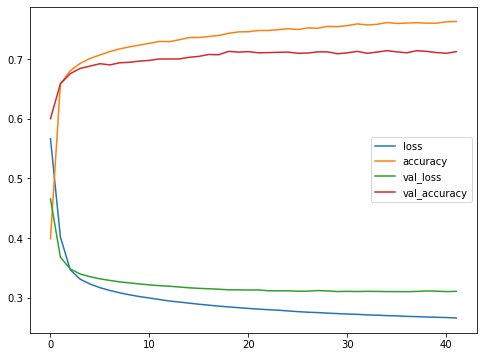

In [206]:
#evaluation
history_dict = history.history
history_dict.keys()
pd.DataFrame(history.history).plot(figsize=(8,6));

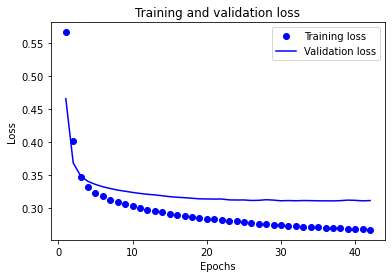

In [207]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(val_loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [208]:
model = build_model(n_inputs, n_outputs)
model.fit(X_train, y_train,epochs=42, verbose=0)
model.evaluate(X_test, y_test)

79/79 [==============================] - 0s 1ms/step - loss: 0.3115 - accuracy: 0.7099


[0.31149497628211975, 0.7099206447601318]

In [209]:
#predict
yhat = model.predict(X_test)
yhat = yhat.round()
print('Predict\n',yhat[0:5])
print('Real\n',y_test[0:5])
acc = accuracy_score(y_test, yhat)
print('Accuracy ',acc)

Predict
 [[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]
Real
 [[0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [0 1 0 0]
 [1 0 0 0]]
Accuracy  0.6861111111111111


# Model 2 (Random Forest)

In [210]:
#Prepare data
df.loc[df['Class']=='Q1','Class'] = 0
df.loc[df['Class']=='Q2','Class'] = 1
df.loc[df['Class']=='Q3','Class'] = 2
df.loc[df['Class']=='Q4','Class'] = 3

In [211]:
#train-test split
X = df.loc[:, df.columns != 'Class']
y = df['Class'] 
y=y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [212]:
#normalization (all except dummies)
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#X_trainN = scaler.fit_transform(X_train.iloc[:,1:9])
#X_testN = scaler.transform(X_test.iloc[:,1:9])

#merge normalized data with all dummies
#df_train_dummies = pd.concat([X_train.iloc[:,0],X_train.iloc[:,10:]],axis=1)
#X_train_dummy = np.array(df_train_dummies)
#X_train = np.concatenate((X_trainN,X_train_dummy),axis=1)

#df_test_dummies = pd.concat([X_test.iloc[:,0],X_test.iloc[:,10:]],axis=1)
#X_test_dummy = np.array(df_test_dummies)
#X_test = np.concatenate((X_testN,X_test_dummy),axis=1)

In [213]:
#modeling
model2 = RandomForestClassifier(n_estimators=100)
model2.fit(X_train,y_train)

RandomForestClassifier()

In [214]:
y_pred=model2.predict(X_test)

print('pred',y_pred[0:20])
print('real',np.array(y_test[0:20]))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


pred [3 0 3 0 1 3 1 0 0 2 3 1 1 2 0 1 0 2 3 0]
real [3 0 3 0 1 3 0 0 0 2 2 0 0 1 0 1 0 3 3 0]
Accuracy: 0.7912698412698412


Text(0.5, 1.0, 'Visualizing Important Features')

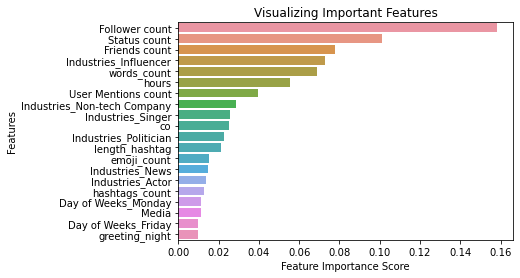

In [215]:
#Important feature
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

feature_imp = pd.Series(model2.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp[0:20]

sns.barplot(x=feature_imp[0:20], y=feature_imp[0:20].index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

In [216]:
#Model Selection
X=df[feature_imp[0:20].index]
y=df['Class']  


y=y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#modeling
model2 = RandomForestClassifier(n_estimators=100)
model2.fit(X_train,y_train)

y_pred=model2.predict(X_test)

print('pred',y_pred[0:20])
print('real',np.array(y_test[0:20]))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


pred [0 1 0 3 0 1 3 0 1 1 0 1 0 2 3 0 0 1 1 3]
real [0 1 0 3 1 3 3 1 2 1 0 1 0 2 2 0 1 1 0 3]
Accuracy: 0.7817460317460317


# Model3 (Multinomial Logistic Regression)

In [217]:
#train-test split
X = df.loc[:, df.columns != 'Class']
y = df['Class'] 
y=y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [218]:
#normalization (all except dummies)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_trainN = scaler.fit_transform(X_train.iloc[:,1:9])
X_testN = scaler.transform(X_test.iloc[:,1:9])

#merge normalized data with all dummies
df_train_dummies = pd.concat([X_train.iloc[:,0],X_train.iloc[:,10:]],axis=1)
X_train_dummy = np.array(df_train_dummies)
X_train = np.concatenate((X_trainN,X_train_dummy),axis=1)

df_test_dummies = pd.concat([X_test.iloc[:,0],X_test.iloc[:,10:]],axis=1)
X_test_dummy = np.array(df_test_dummies)
X_test = np.concatenate((X_testN,X_test_dummy),axis=1)

In [219]:
model3 = LogisticRegression(multi_class='multinomial',solver ='newton-cg').fit(X_train,y_train)
#model3 = LogisticRegression(multi_class='multinomial',solver ='lbfgs',max_iter=1000,penalty='l2').fit(X_train,y_train)

y_pred=model3.predict(X_test)

print('pred',y_pred[0:20])
print('real',np.array(y_test[0:20]))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

pred [1 0 2 1 3 1 0 2 1 1 2 2 1 0 1 3 1 3 0 3]
real [1 0 1 3 2 1 0 2 1 1 2 3 2 0 2 2 1 2 0 2]
Accuracy: 0.7146825396825397
